# 02a_ Introduction to Photometric Correction

- author Sylvie Dagoret-Campagne
- creation date : 2023/02/23
- last verification : 2023/02/24

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'


In [2]:
from scipy import interpolate

## Imports dedicated to this work

- import the atmospheric transparency emulator (instead of using libradtran code).
- import rubin sim
- import libPhotometricCorrections : encapsulate uninteresting calculation details

In [3]:
from importlib.metadata import version
the_ver = version('atmosphtransmemullsst')
print(f"Version of atmosphtransmemullsst : {the_ver}")

Version of atmosphtransmemullsst : 0.0.1


In [4]:
import atmosphtransmemullsst
from atmosphtransmemullsst.simpleatmospherictransparencyemulator import SimpleAtmEmulator

emul = SimpleAtmEmulator(os.path.join(atmosphtransmemullsst.__path__[0],'../data/simplegrid'))

SimpleAtmEmulator:path=/Users/dagoret/MacOSX/GitHub/LSST/atmosphtransmemullsst/atmosphtransmemullsst/../data/simplegrid


In [5]:
WL = emul.GetWL()

In [6]:
import sys
sys.path.append('../lib')
import libAtmosphericFit

libAtmosphericFit.py :: Use atmosphtransmemullsst.__path__[0],'../data/simplegrid as the path to data
libAtmosphericFit.py :: data_path = /Users/dagoret/MacOSX/GitHub/LSST/atmosphtransmemullsst/atmosphtransmemullsst/../data/simplegrid
SimpleAtmEmulator:path=/Users/dagoret/MacOSX/GitHub/LSST/atmosphtransmemullsst/atmosphtransmemullsst/../data/simplegrid


In [7]:
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections import *

libPhotometricCorrections.py :: Use atmosphtransmemullsst.__path__[0],'../data/simplegrid as the path to data
libPhotometricCorrections :: data_path = /Users/dagoret/MacOSX/GitHub/LSST/atmosphtransmemullsst/atmosphtransmemullsst/../data/simplegrid
SimpleAtmEmulator:path=/Users/dagoret/MacOSX/GitHub/LSST/atmosphtransmemullsst/atmosphtransmemullsst/../data/simplegrid


In [8]:
import rubin_sim.photUtils.Bandpass as Bandpass
import rubin_sim.photUtils.Sed as Sed
from rubin_sim.data import get_data_dir

## Configuration

## Standard atmosphere

In [9]:
am0 =1.20    # airmass
pwv0 = 5.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = -1# Aerosol Angstrom exponent

### Initialisation of Atmospheric corrections

In [10]:
pc = PhotometricCorrections(am0,pwv0,oz0,ncomp,tau0,beta0)

### Check standard atmosphere

Text(0.5, 1.0, 'Standard atmosphere transmission')

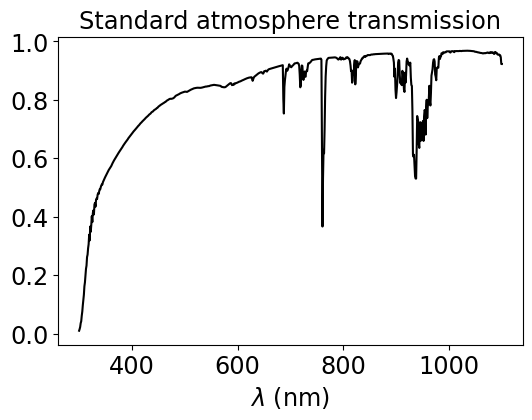

In [11]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(pc.WL,pc.atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

### Check instrument throughput

Text(0.5, 1.0, 'Instrument throughput')

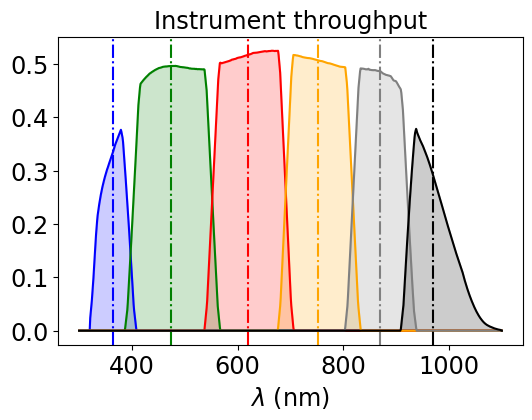

In [12]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument throughput")

### Check standard Filter throughputs

Text(0.5, 1.0, 'Total filter throughput')

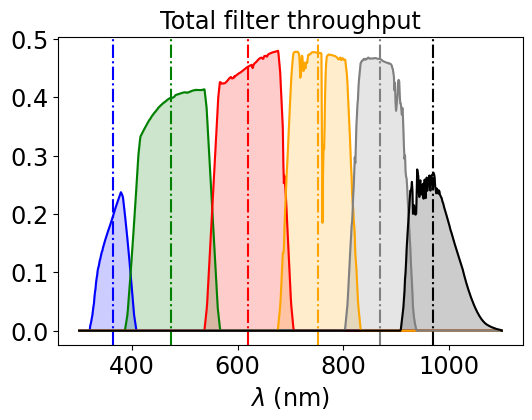

In [13]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total filter throughput")

### Check standard normalised filter total response

Text(0.5, 1.0, 'Normalised filter total response $\\phi_b(\\lambda)$')

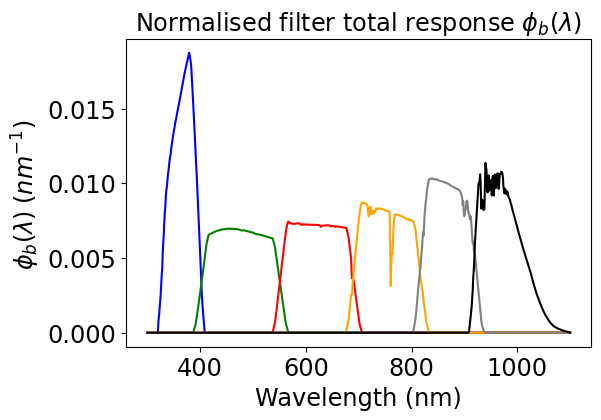

In [14]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
for index,f in enumerate(filter_tagnames):
    ax.plot(pc.WL,pc.phiArray_std[index,:],'-',color=filter_color[index],label = f)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$\phi_b(\lambda)\; (nm^{-1})$ ")
ax.set_title("Normalised filter total response $\phi_b(\lambda)$")

### Check standard Integrals

In [15]:
pc.all_II0_std

{'u': 0.03342769116035513,
 'g': 0.1221242504398316,
 'r': 0.10116768892516816,
 'i': 0.07750051493971546,
 'z': 0.05375682875091482,
 'y': 0.025892194834450773}

In [16]:
pc.all_II1_std

{'u': 2.3476762731276044,
 'g': 2.5482606447984644,
 'r': 0.9752671488769777,
 'i': 0.2935845227015852,
 'z': -0.5067377055362723,
 'y': 3.567503680789848}

### Introduction and Review on Photometric corrections

### Reminder on what kind of flux we want to calculate 

- the Flux in each band $b$ at the TOP of atmosphere

$$
F_{b\;AB}^{std} = \frac{1}{F_{0}} \int \phi_{b}^{std}(\lambda) F_\nu({\lambda})d\lambda
$$

where:
- $F_{0}$ is a constant such as $F_0^{AB}=3631$ Jy with $1 Jy = 10^{-23} erg.cm^{-2}.s^{-1}.Hz^{-1}$,
- $F_\nu(\lambda)$ is the SED (Spectral Energy Distribution) of the object in Jansky unit. In general $F_\nu(\lambda)$ is unknown or poorly known after identification/classification of the object, 
- $\phi_{b}^{std}(\lambda)$ : is the standard normalised response of the telescope (including atmosphere and hardware electronics and optics):

$$
\phi^{std}_b(\lambda) = \frac{S_b^{std}(\lambda) \frac{1}{\lambda}}{\int S_b^{std}(\lambda) \frac{d \lambda}{\lambda}}
$$

- $S_b^{std}(\lambda)$ is **the defined** LSST survey total transmission of the instrument + atmosphere, taken to be the most probable or average or median total transmission:
$$
S_b^{std}(\lambda) = S^{std}_{atm}(\lambda) \times S_{b\; inst}^{std}(\lambda)
$$
It is defined at a particular airmass, a particular atmospheric transmission and a particular hardware-optics+electronics setting.


Note if $F_{b\; AB}^{std}$ is a quantity that we have to calculate from the known $\phi_b^{std}$, the true SED $F_\nu$ is in principle unknown : we have
to measure something !
This is the per exposure ADC photometric count in band $b$: 
$$
ADC_b^{std} = \frac{A \Delta T}{g_{el}h} \int S_{b}^{std}(\lambda) F_\nu(\lambda) \frac{d\lambda}{\lambda}
$$

- $ADC_b^{std}$ is the expected number of counts, after correction from Instrument Signature Removal, including CCD unflattening and aperture photmetry on the object.
- $A$, $\Delta T$, $g_{el}$ are the instrument constants, respectively Surface collection, Exposure-time, electronic gain . They are much poorely known at the percent level.
- $h$ is the Planck constant.

The point is that we never measure ADC counts with a  $S_{b}^{std}(\lambda)$ transmission. We measure $ADC_b^{obs}$ (after ISR and unflattening on the image and aperture photometry on the object) for each visit of the object
for a also measured transmission $S_{b}^{obs}(\lambda)$.

$$
ADC_b^{obs} = \frac{A \Delta T}{g_{el}h} \int S_{b}^{obs}(\lambda) F_\nu(\lambda) \frac{d\lambda}{\lambda}
$$

### Goal of Photometric Correction
**So the goal of Photometric correction is to calculate for each visit  the flux in the observed band $b$ : $F_{b\;AB}^{std}$ from the measured $ADC_b^{obs}$,
for a calibrated $S_b^{obs}(\lambda)$ or equivalently $\phi_b^{obs}(\lambda)$ given a defined $S_b^{std}(\lambda)$ or equivalently $\phi_b^{std}(\lambda)$.** 

After rearranging the above equation, one get the AB flux per visit in LSST standard band $b$:

$$
F_{b\; AB}^{std} = \frac{g_{el} h}{A \Delta T} \frac{ADU^{obs}_b}{\mathbb{I}_{0\,b}^{obs}} \frac{\int \phi_b^{std}(\lambda) F_\nu(\lambda) d\lambda}{\int \phi_b^{obs}(\lambda) F_\nu(\lambda) d\lambda}
$$

where the integral  $\mathbb{I}_{0\,b}^{obs}$ is defined as :
$$
\mathbb{I}_{0\,b}^{obs} = \int S_{b}^{obs}(\lambda) \frac{d\lambda}{\lambda} 
$$

- The interpretation of $\mathbb{I}_{0\,b}^{obs}$ correspond to the calculation of an average attenuation in the $b$ band.
This term compensates the variation of the band absorption measured $ADU_b^{obs}$, thus correcting at zeroth order $F_{b\; AB}^{std}$.

Note if we don't know $S_b^{obs}(\lambda)$, we have to replace at zeros order the unknown integral  $\mathbb{I}_{0\,b}^{obs}$ by the known defined integral  $\mathbb{I}_{0\,b}^{std} = \int S_{b}^{std}(\lambda) \frac{d\lambda}{\lambda}$. However any variation of the absorption in the filter band $b$ would not be compensated.

- The term of constants $\frac{g_{el} h}{A \Delta T}$ is poorly known because we don't know these constants at the percent level (except $h$). 
This term is referred as the zero point term. It is a calibration constant that must be determined by a dedicated Zero-point calibration procedure
for each visit, for each CCD from a series of calibration stars seen on the CCD plate. It is a kind of time dependent grey term to be applied band per band , CCD per CCD.

- The term of constants $\frac{g_{el} h}{A \Delta T}$ is poorly known because we don't know these constants at the percent level (except $h$). 

- The term $ \frac{\int \phi_b^{std}(\lambda) F_\nu(\lambda) d\lambda}{\int \phi_b^{obs}(\lambda) F_\nu(\lambda) d\lambda}$ refer explicitely to the unknown SED $F_\nu(\lambda)$. Tthis is why one refer as the color term in the band $b$. This is term is close to unity. If observations conditions are close to standard condtions, this term is close to 1. If the SED shape is close to that of a flat source, like an ideal AB source, this term is close to 1. If the SED has a sharp slope in the band, this term may not be negligible compared to the expected photometric accuracy.

The we could aim to guess $F_\nu(\lambda)$ shape from the measured average $< F_{b\; AB}^{std} >$ for that object.
By expanding the SED shape at first order in the $b$ band:
$$
F_\nu(\lambda) \simeq F_\nu(\lambda_b)\left(1 +  f^{\prime}(\lambda_b)(\lambda- \lambda_b)\right)
$$



$$
F_{b\; AB}^{std} = \frac{g_{el} h}{A \Delta T} \frac{ADU^{obs}_b}{\mathbb{I}_{0\,b}^{obs}} 
\left(1 + f^{\prime}(\lambda_b)(\Pi_{1\,b}^{std} -  \Pi_{1\,b}^{obs}) \right)
$$

where the integral $\mathbb{I}_{1\, b}$ is defined as :
$$
\mathbb{I}_{1\, b}^{obs} = \int (\lambda - \lambda_b) \phi_{b}^{obs}(\lambda) d\lambda
$$
$$
\mathbb{I}_{1\, b}^{std} = \int (\lambda - \lambda_b) \phi_{b}^{std}(\lambda) d\lambda
$$


  Note the term $F_\nu(\lambda_b)$ is eliminated, only the relative derivate $f^\prime(\lambda_b) = \frac{1}{F_\nu(\lambda_b)}\frac{dF\nu}{d\lambda}(\lambda_b)$ matters.

*For example for conditions such that $obs \simeq std$, color corrections are small, one measure $F_{b\; AB}^{std}$ with low bias, whereas for conditions where $obs \neq std$, we estimate $f^\prime(\lambda_b)$.*

The standard magnitude per visit reads:

$$
m_{b\, AB}^{std} = -2.5 \log_{10}(ADU^{obs}_b) + 2.5 \log_{10} \frac{\Pi_{0\,b}^{obs}}{\Pi_{0\,b}^{std}} + \frac{2.5}{\ln(10)}f^{\prime}(\lambda_b)(\Pi_{1\,b}^{std} -  \Pi_{1\,b}^{obs}) + ZPT
$$


- $-2.5 \log_{10}(ADU^{obs}_b)$ is the instrumental magnitude
- $2.5 \log_{10} \frac{\Pi_{0\,b}^{obs}}{\Pi_{0\,b}^{std}}$ is the zeros-th order correction for band relative attenuation (compared to standard attenuation)
- $\frac{2.5}{\ln(10)}f^{\prime}(\lambda_b)(\Pi_{1\,b}^{std} -  \Pi_{1\,b}^{obs})$ is the first-order color term correction
- $ZPT =  2.5 \log_{10} \left(\frac{g_{el} h}{A \Delta T} \right)  + 2.5 \log_{10}(\Pi_{0\,b}^{std})$ is the source independent and transmission variation independent zero point that does not need to be calculated to be evaluated CCD per CCD, visit per visit using several photometric calibration sources in LSST FOV.

# Summary on Photometric correction goals

We propose to calibrate sources Fluxes in AB unit, by correcting instrumental magnitudes, band by band, visit per visit independently. 
We are able to separate the contribution of the atmoshere from the unknown SED colors.
For this calibration we requires to monitor the transmission integrals :

- $2.5 \log_{10} \frac{\Pi_{0\,b}^{obs}}{\Pi_{0\,b}^{std}}$ to correct magnitude at zeros-th order for any band-average grey attenuation,
- $(\Pi_{1\,b}^{std} -  \Pi_{1\,b}^{obs})$ to correct magnitude at first order for SED colors,
  
  
- In addition a method to derive the photometrical zero point ZPT must be studied in this DEC-PC group (this subject is not adressed for the moment),

- Aperture Photometric accuracy including sky background contribution in $-2.5 \log_{10}(ADU^{obs}_b)$ is still an open field in DESC-PC group.

In this notebook, we focus on the impact of atmospheric variations on
$2.5 \log_{10} \frac{\Pi_{0\,b}^{obs}}{\Pi_{0\,b}^{std}}$  and $(\Pi_{1\,b}^{std} -  \Pi_{1\,b}^{obs})$ 

# Numerical applications to Photometric corrections

## Airmass variation

In [17]:
all_am = np.linspace(1,2.5,16)
NAM=len(all_am)
pwv= 5.0
oz = 300
ncomp =1
tau= 0.04
beta = -1

In [18]:
all_am_tags = []
for index,am in enumerate(all_am):
    am_tag = "am_"+str(int(am*10))
    all_am_tags.append(am_tag)
all_am_tags=np.array(all_am_tags)
all_am_tags

array(['am_10', 'am_11', 'am_12', 'am_13', 'am_14', 'am_15', 'am_16',
       'am_17', 'am_18', 'am_19', 'am_20', 'am_21', 'am_22', 'am_23',
       'am_24', 'am_25'], dtype='<U5')

In [19]:
pc.CalculateMultiObs(all_am,pwv,oz,ncomp,tau,beta)

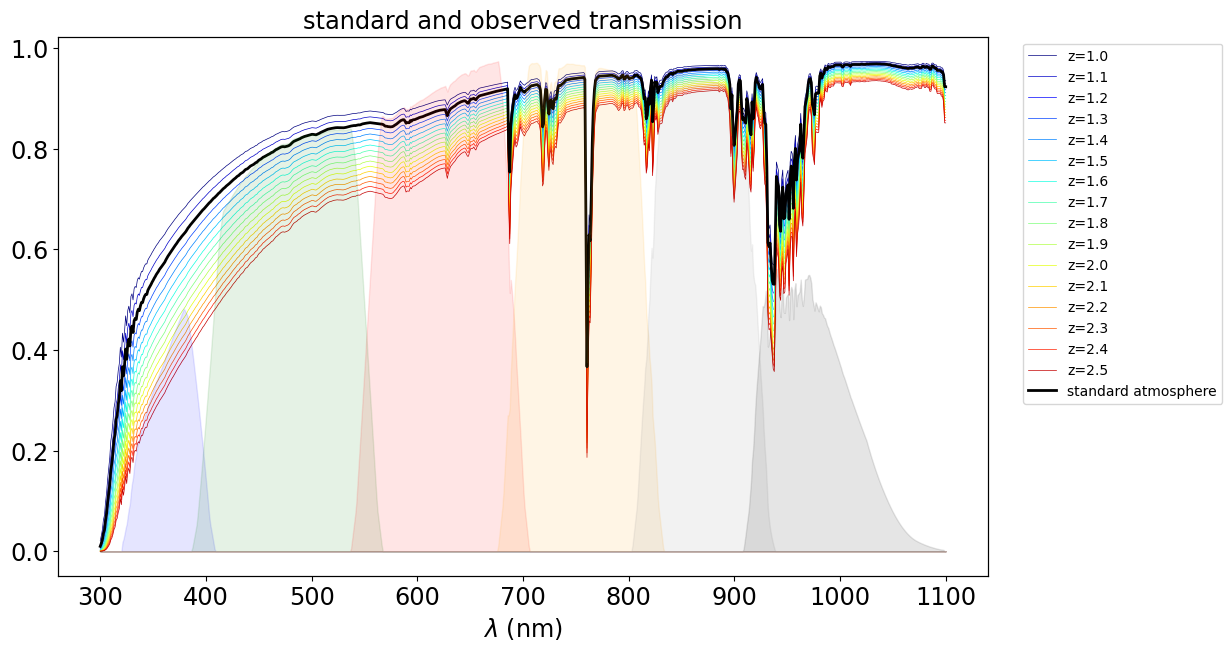

In [20]:
NOBS = len(all_am)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig, axs = plt.subplots(1,1,figsize=(12,7))

for index,am in enumerate(all_am):
  
    atm = pc.coll_atm_nonstd[index]
    am = all_am[index]
    label = f"z={am:.1f}"
    
    
    axs.plot(pc.WL,atm,color=all_colors[index],label=label,lw=0.5)


    
axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")


ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])



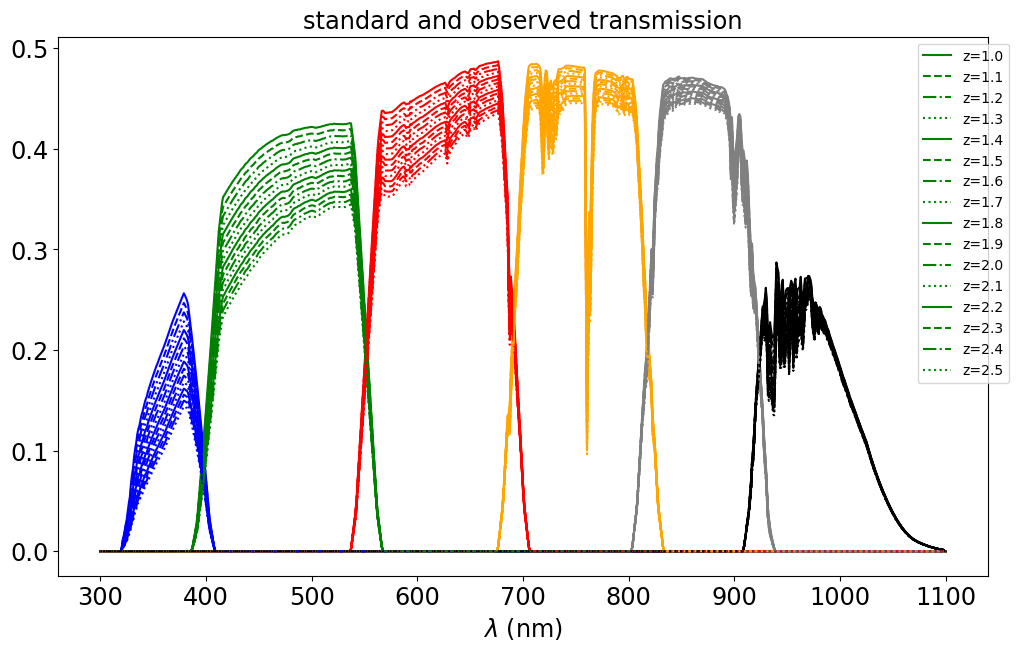

In [21]:
fig, axs = plt.subplots(1,1,figsize=(12,7))

all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':']


for idx_am,am in enumerate(all_am):
    
    
    label = f"z={am:.1f}"
    
    for ifilt,f in enumerate(filter_tagnames):
        x=pc.coll_bandpass_total_nonstd[idx_am][f].wavelen
        y=pc.coll_bandpass_total_nonstd[idx_am][f].sb 
        
        if ifilt==1:
            axs.plot(x,y,color=filter_color[ifilt],linestyle=all_linestyles[idx_am],label=label )
        else:
            axs.plot(x,y,color=filter_color[ifilt],linestyle=all_linestyles[idx_am])

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")
axs.legend(bbox_to_anchor=(1.03, 1.0))  

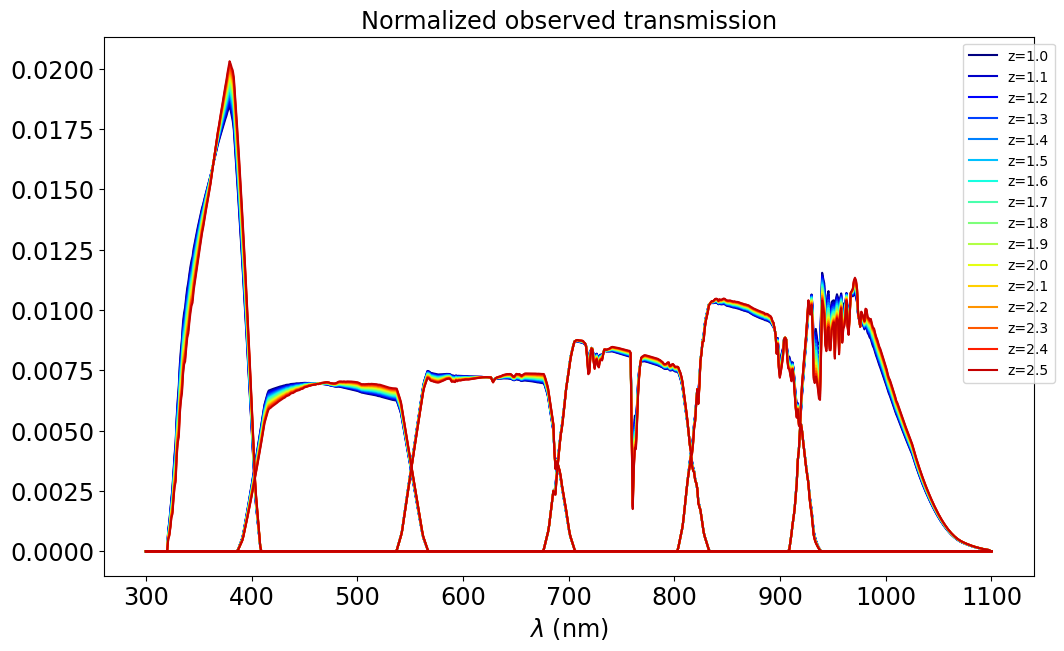

In [22]:
fig, axs = plt.subplots(1,1,figsize=(12,7))

all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':']

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


for idx_am,am in enumerate(all_am):
    
    
    label = f"z={am:.1f}"
    
    for ifilt,f in enumerate(filter_tagnames):
        
        the_x=pc.WL
        the_y=pc.coll_phiArray_nonstd[idx_am][ifilt,:]
       
        
        if ifilt==1:
            axs.plot(the_x,the_y,color=all_colors[idx_am],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_y,color=all_colors[idx_am],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Normalized observed transmission")
axs.legend(bbox_to_anchor=(1.03, 1.0))  

### Airmass variation : Observed filter and normalized response

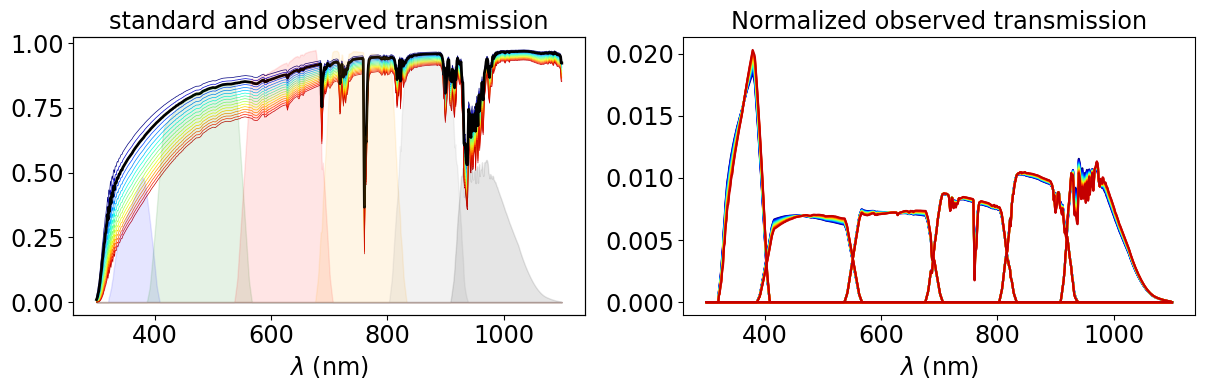

In [23]:
NOBS = len(all_am)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(12,4))

# Figure 1
axs=fig.add_subplot(1,2,1)
for index,am in enumerate(all_am):
  
    atm = pc.coll_atm_nonstd[index]
    am = all_am[index]
    label = f"z={am:.1f}" 
    axs.plot(pc.WL,atm,color=all_colors[index],label=label,lw=0.5)
   
axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])



# Figure 2
axs=fig.add_subplot(1,2,2)

all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':']

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)

for idx_am,am in enumerate(all_am):
       
    label = f"z={am:.1f}"
    
    for ifilt,f in enumerate(filter_tagnames):
        
        the_x=pc.WL
        the_y=pc.coll_phiArray_nonstd[idx_am][ifilt,:]
       
        
        if ifilt==1:
            axs.plot(the_x,the_y,color=all_colors[idx_am],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_y,color=all_colors[idx_am],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Normalized observed transmission")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  


plt.tight_layout()
plt.show()



### airmass variation : $2.5 \log_{10} (II_0^{obs}(b)/II_0^{std}(b))$ and  $II_{1}^{std}(b)-II_{1}^{obs}(b)$

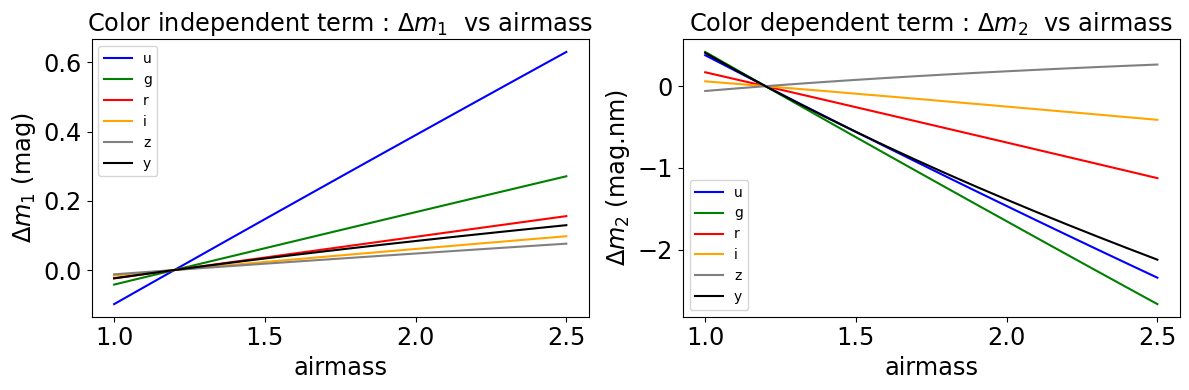

In [24]:
fig = plt.figure(figsize=(12,4))

# Figure 1
ax=fig.add_subplot(1,2,1)

Y = np.zeros(NAM)
for ifilt,f in enumerate(filter_tagnames):
    # loop on airmass
    for index_am,am in enumerate(all_am):
        the_II0_ratio = pc.coll_all_II0ratio_nonstd[index_am][f]
        
        Y[index_am] = -2.5*np.log10(the_II0_ratio)
    ax.plot(all_am,Y,'-',color=filter_color[ifilt],label=f)
ax.set_xlabel('airmass')
ax.set_ylabel('$\Delta m_1$ (mag)')
ax.set_title('Color independent term : $\Delta m_1$  vs airmass')
ax.legend()
          

# Figure 2
ax=fig.add_subplot(1,2,2)
Y = np.zeros(NAM)
for ifilt,f in enumerate(filter_tagnames):
    # loop on airmass
    for index_am,am in enumerate(all_am):
        the_II1_sub = pc.coll_all_II1sub_nonstd[index_am][f]
        Y[index_am] = the_II1_sub
    ax.plot(all_am,Y,'-',color=filter_color[ifilt],label=f)
ax.set_xlabel('airmass')
ax.set_ylabel('$\Delta m_2$ (mag.nm)')
ax.set_title('Color dependent term : $\Delta m_2$  vs airmass')
ax.legend()
plt.tight_layout()
plt.show()



/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_22646/3059100578.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


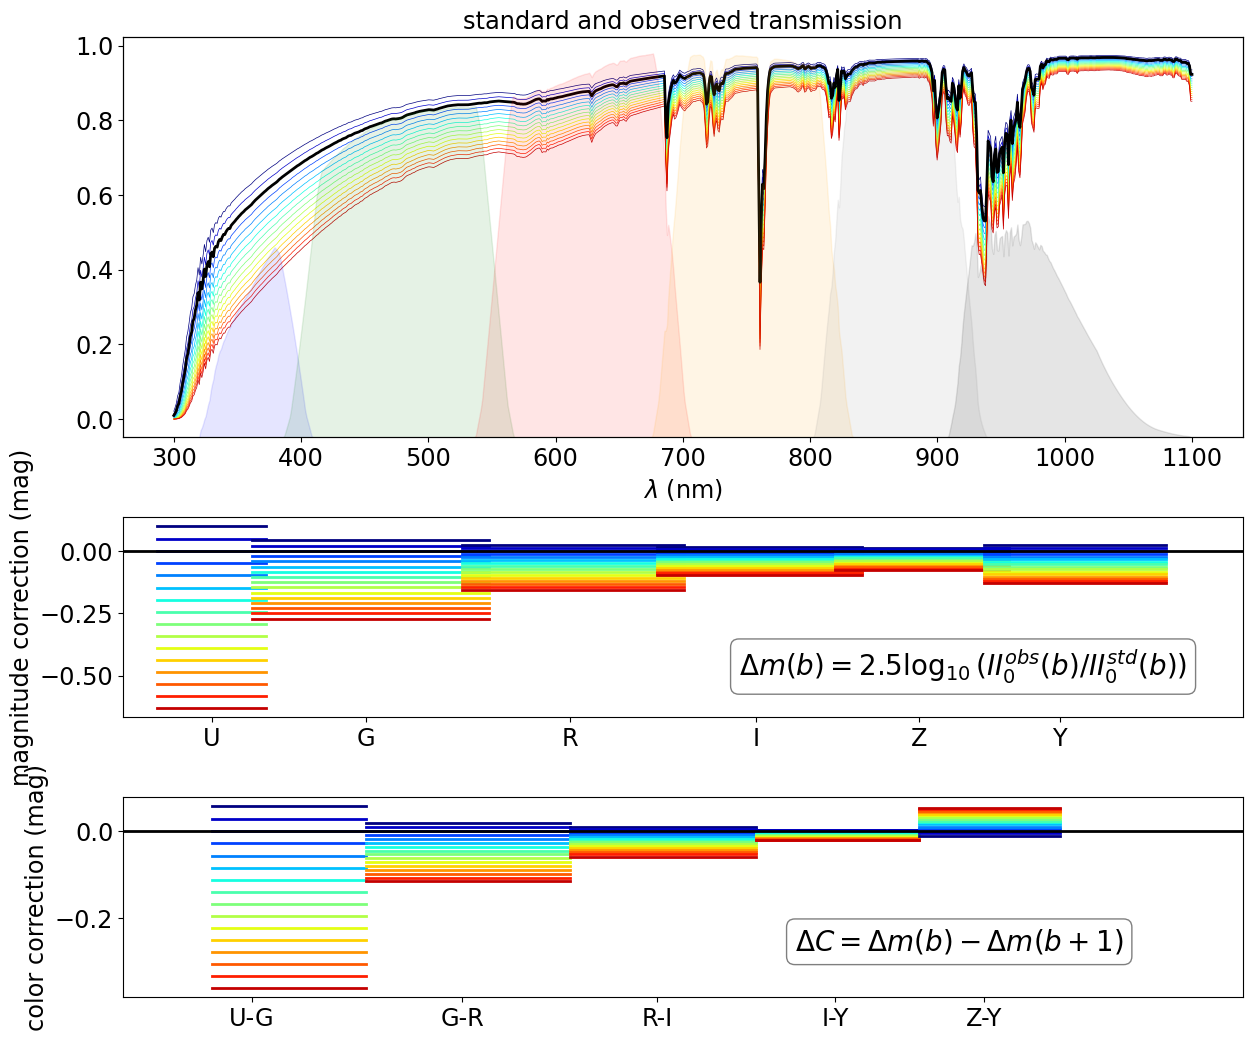

In [25]:
# wavelength bin colors
NOBS = len(all_am)

jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(14,12))

gs = fig.add_gridspec(3, 1,  height_ratios=(3, 1.5, 1.5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.3)
###############
#top figure
###############
axs = fig.add_subplot(gs[0, 0])

for idx_am,am in enumerate(all_am):
    atm  = pc.coll_atm_nonstd[idx_am]
   
    label = f"z={am:.1f}"
    
    axs.plot(WL,atm,color=all_colors[idx_am],label=label,lw=0.5)


axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])    
    
ax2.set_ylim(0,0.5)

###################
#middle figure
#################

axs2 = fig.add_subplot(gs[1, 0])
# external loop on filters
for ifilt,f in enumerate(filter_tagnames):
    the_div_mag = np.zeros(NAM) # container
    # internal loop on airmass to get the difference on II
    for idx_am,am in enumerate(all_am):
        the_II0_ratio = pc.coll_all_II0ratio_nonstd[idx_am][f]
        the_div_mag[idx_am]= 2.5*np.log10(the_II0_ratio)
        xx= [FILTERWL[ifilt,0],FILTERWL[ifilt,1]]
        yy= [the_div_mag[idx_am],the_div_mag[idx_am]]
        axs2.plot(xx,yy,color=all_colors[idx_am],lw=2)
axs2.set_xlim(WLMIN,WLMAX)
axs2.axhline(y=0,lw=2,color="k")
axs2.set_xticks(FILTERWL[:,2])
axs2.set_xticklabels(Filter_tagnames, minor=False)
axs2.set_ylabel("magnitude correction (mag)")
#axs2.grid()
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='w', alpha=0.5)

textstr="$\Delta m(b) = 2.5 \log_{10} (II_0^{obs}(b)/II_0^{std}(b))$"
#axs2.set_title(textstr)
# place a text box in upper left in axes coords
axs2.text(0.55, 0.35, textstr, transform=axs2.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)


###############################
# bottom figure
###############################
axs3 = fig.add_subplot(gs[2, 0])

for ifilt,f in enumerate(filter_tagnames):
    if ifilt == NFILT-1:
        break
    fnext = filter_tagnames[ifilt+1]
    
    the_div_mag = np.zeros(NAM)
    # loop on airmass to get the difference on II
    for idx_am,am in enumerate(all_am):
        the_II0_ratio1 = pc.coll_all_II0ratio_nonstd[idx_am][f]
        the_II0_ratio2 = pc.coll_all_II0ratio_nonstd[idx_am][fnext]
        
        dcolor = 2.5*np.log10( the_II0_ratio1)-2.5*np.log10(the_II0_ratio2)
        xx= [FILTERWL[ifilt,2],FILTERWL[ifilt+1,2]]
        yy= [dcolor,dcolor]
        axs3.plot(xx,yy,color=all_colors[idx_am],lw=2)
axs3.set_xlim(WLMIN,WLMAX)
axs3.axhline(y=0,lw=2,color="k")
#axs3.set_xlabel("$\lambda$ (nm)")

axs3.set_xticks(FILTERWL[1:,0])
axs3.set_xticklabels(Filtercolor_tagnames, minor=False)

axs3.set_ylabel("color correction (mag)")
#axs3.grid()
textstr="$\Delta C = \Delta m(b) - \Delta m(b+1)$"
#axs2.set_title(textstr)
# place a text box in upper left in axes coords
axs3.text(0.60, 0.35, textstr, transform=axs3.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)


plt.tight_layout()    

## Variation of PWV

In [26]:
am = 1.2
oz = 300
ncomp =1
tau= 0.04
beta = -1
all_pwv = np.arange(0,10,0.5)
NPWV = len(all_pwv)

In [27]:
pc.CalculateMultiObs(am,all_pwv,oz,ncomp,tau,beta)

### PWV variation :  Observed filter and normalized response

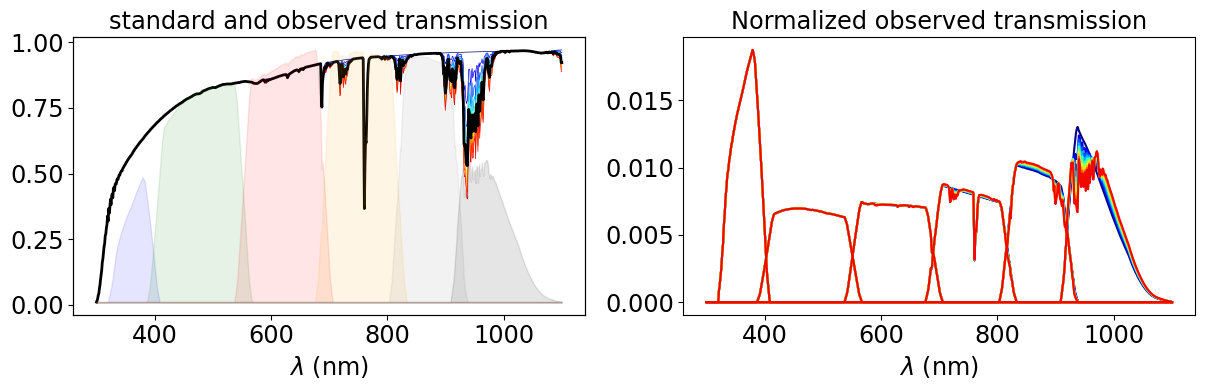

In [28]:
NOBS = len(all_pwv)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(12,4))

# Figure 1
axs=fig.add_subplot(1,2,1)
for index,pwv in enumerate(all_pwv):
  
    atm = pc.coll_atm_nonstd[index]
    
    label = f"pwv={pwv:.1f}" 
    axs.plot(pc.WL,atm,color=all_colors[index],label=label,lw=0.5)
   
axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])



# Figure 2
axs=fig.add_subplot(1,2,2)

all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':']

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


for idx_pwv,pwv in enumerate(all_pwv):
    
    
    label = f"z={am:.1f}"
    
    for ifilt,f in enumerate(filter_tagnames):
        
        the_x=pc.WL
        the_y=pc.coll_phiArray_nonstd[idx_pwv][ifilt,:]
       
        
        if ifilt==1:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Normalized observed transmission")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  


plt.tight_layout()
plt.show()



### PWV variation : $2.5 \log_{10} (II_0^{obs}(b)/II_0^{std}(b))$ and  $II_{1}^{std}(b)-II_{1}^{obs}(b)$

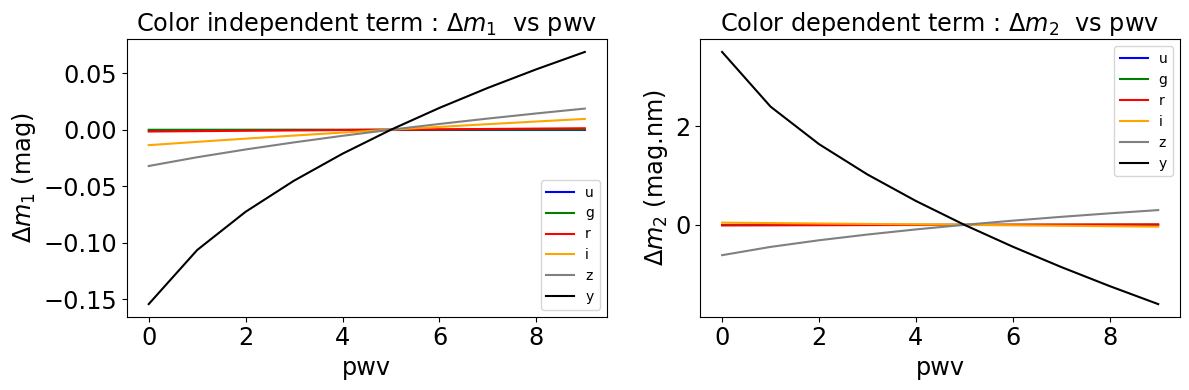

In [29]:
fig = plt.figure(figsize=(12,4))

# Figure 1
ax=fig.add_subplot(1,2,1)

Y = np.zeros(NPWV)
for ifilt,f in enumerate(filter_tagnames):
    # loop on airmass
    for index_pwv,pwv in enumerate(all_pwv):
        the_II0_ratio = pc.coll_all_II0ratio_nonstd[index_pwv][f]
        
        Y[index_pwv] = -2.5*np.log10(the_II0_ratio)
    ax.plot(all_pwv,Y,'-',color=filter_color[ifilt],label=f)
ax.set_xlabel('pwv')
ax.set_ylabel('$\Delta m_1$ (mag)')
ax.set_title('Color independent term : $\Delta m_1$  vs pwv')
ax.legend()
          

# Figure 2
ax=fig.add_subplot(1,2,2)
Y = np.zeros(NPWV)
for ifilt,f in enumerate(filter_tagnames):
    # loop on airmass
    for index_pwv,pwv in enumerate(all_pwv):
        the_II1_sub = pc.coll_all_II1sub_nonstd[index_pwv][f]
        Y[index_pwv] = the_II1_sub
    ax.plot(all_pwv,Y,'-',color=filter_color[ifilt],label=f)
ax.set_xlabel('pwv')
ax.set_ylabel('$\Delta m_2$ (mag.nm)')
ax.set_title('Color dependent term : $\Delta m_2$  vs pwv')
ax.legend()
plt.tight_layout()
plt.show()



/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_22646/2358006418.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


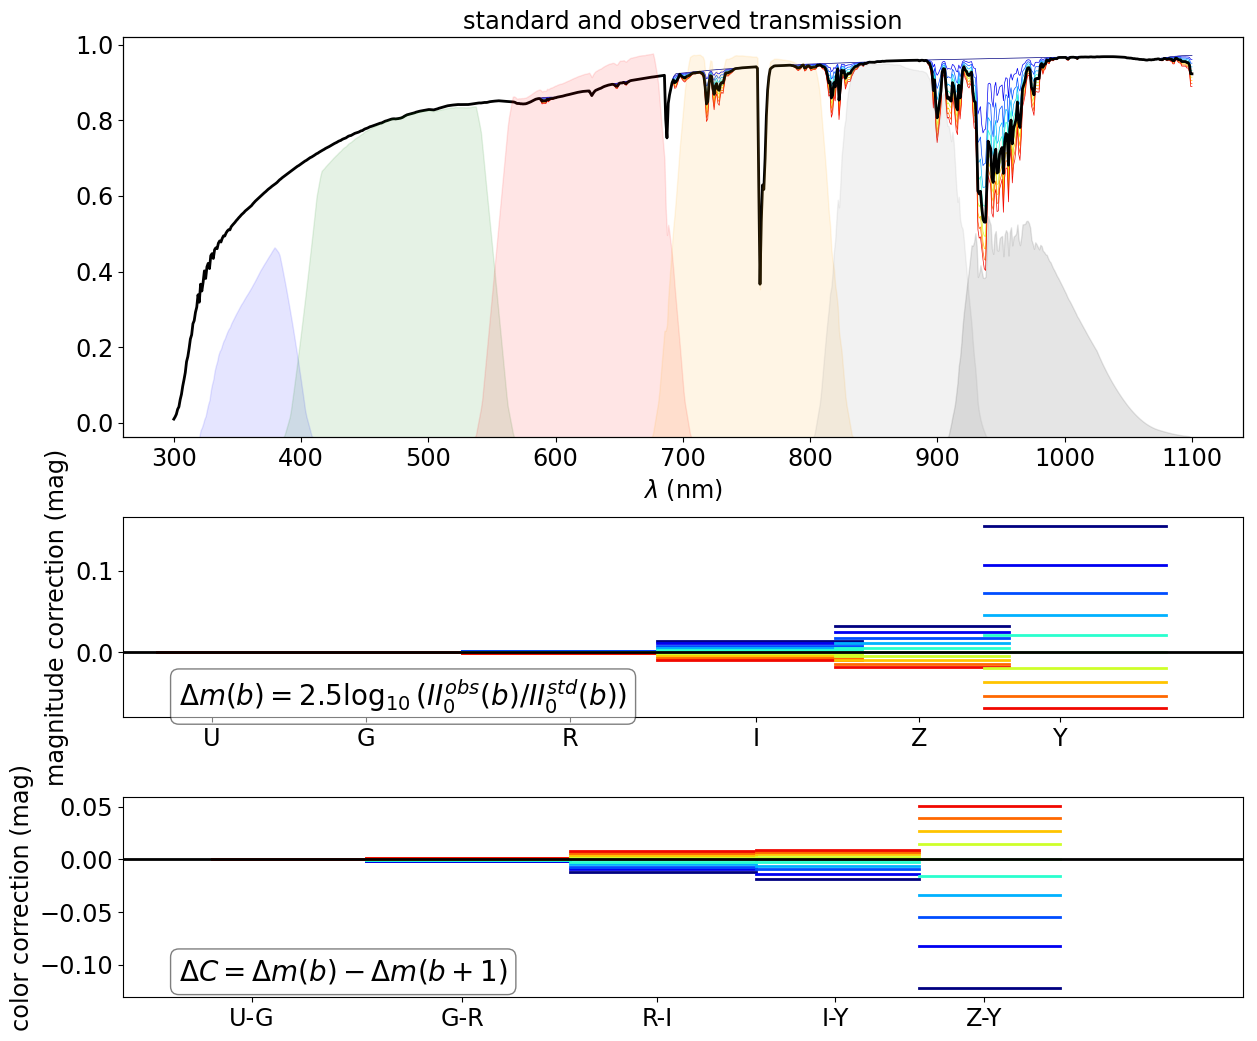

In [30]:
# wavelength bin colors
NOBS = len(all_pwv)

jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(14,12))

gs = fig.add_gridspec(3, 1,  height_ratios=(3, 1.5, 1.5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.3)
###############
#top figure
###############
axs = fig.add_subplot(gs[0, 0])

for idx_pwv,pwv in enumerate(all_pwv):
    atm  = pc.coll_atm_nonstd[idx_pwv]
   
    label = f"pwv={pwv:.1f}"
    
    axs.plot(WL,atm,color=all_colors[idx_pwv],label=label,lw=0.5)


axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])    
    
ax2.set_ylim(0,0.5)

###################
#middle figure
#################

axs2 = fig.add_subplot(gs[1, 0])
# external loop on filters
for ifilt,f in enumerate(filter_tagnames):
    the_div_mag = np.zeros(NPWV) # container
    # internal loop on airmass to get the difference on II
    for idx_pwv,pwv in enumerate(all_pwv):
        the_II0_ratio = pc.coll_all_II0ratio_nonstd[idx_pwv][f]
        the_div_mag[idx_pwv]= 2.5*np.log10(the_II0_ratio)
        xx= [FILTERWL[ifilt,0],FILTERWL[ifilt,1]]
        yy= [the_div_mag[idx_pwv],the_div_mag[idx_pwv]]
        axs2.plot(xx,yy,color=all_colors[idx_pwv],lw=2)
axs2.set_xlim(WLMIN,WLMAX)
axs2.axhline(y=0,lw=2,color="k")
axs2.set_xticks(FILTERWL[:,2])
axs2.set_xticklabels(Filter_tagnames, minor=False)
axs2.set_ylabel("magnitude correction (mag)")
#axs2.grid()
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='w', alpha=0.5)

textstr="$\Delta m(b) = 2.5 \log_{10} (II_0^{obs}(b)/II_0^{std}(b))$"
#axs2.set_title(textstr)
# place a text box in upper left in axes coords
#axs2.text(0.55, 0.35, textstr, transform=axs2.transAxes, fontsize=20,
#        verticalalignment='top', bbox=props)
axs2.text(0.05, 0.2, textstr, transform=axs2.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)

###############################
# bottom figure
###############################
axs3 = fig.add_subplot(gs[2, 0])

for ifilt,f in enumerate(filter_tagnames):
    if ifilt == NFILT-1:
        break
    fnext = filter_tagnames[ifilt+1]
    
    the_div_mag = np.zeros(NPWV)
    # loop on pwv to get the difference on II
    for idx_pwv,pwv in enumerate(all_pwv):
        the_II0_ratio1 = pc.coll_all_II0ratio_nonstd[idx_pwv][f]
        the_II0_ratio2 = pc.coll_all_II0ratio_nonstd[idx_pwv][fnext]
        
        dcolor = 2.5*np.log10( the_II0_ratio1)-2.5*np.log10(the_II0_ratio2)
        xx= [FILTERWL[ifilt,2],FILTERWL[ifilt+1,2]]
        yy= [dcolor,dcolor]
        axs3.plot(xx,yy,color=all_colors[idx_pwv],lw=2)
axs3.set_xlim(WLMIN,WLMAX)
axs3.axhline(y=0,lw=2,color="k")
#axs3.set_xlabel("$\lambda$ (nm)")

axs3.set_xticks(FILTERWL[1:,0])
axs3.set_xticklabels(Filtercolor_tagnames, minor=False)

axs3.set_ylabel("color correction (mag)")
#axs3.grid()
textstr="$\Delta C = \Delta m(b) - \Delta m(b+1)$"
#axs2.set_title(textstr)
# place a text box in upper left in axes coords
#axs3.text(0.60, 0.35, textstr, transform=axs3.transAxes, fontsize=20,
#        verticalalignment='top', bbox=props)
axs3.text(0.05, 0.2, textstr, transform=axs3.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)

plt.tight_layout()    